# Six for a Spell Solver

"Six for a Spell", by Will Shortz, appeared in the New York Times special puzzle edition December 18, 2016.

> How many common words of exactly 6 letters can you find?  Words must be spelled sequentially by following the lines connecting circles.  ...  You may use a letter more than once -- but not twice in a row.  Capitalized words are not allowed.  Finding 12 words is good; 22 is excellent; 32 is genius.  Our answer list has 37 words.

In [1]:
%matplotlib inline

## The Dictionary

As with most word puzzles, the list of words to use is very important. I am only considering word sources that load from disk, since the general strategy is to iterate through many words.

As I was working on this, I tried three different sources:
- `/usr/share/dict/words` which is freely available on Linux systems.  But this is not a great source for rare words found in puzzles.
- `enchant` - Great source of words, but it is no longer maintained.
- `nltk` - WordNet list of words is great.


### Linux dictionary

In [2]:
!head -n 9000 /usr/share/dict/words | tail -n 5

Judaeo
Judah
Judah's
Judaic
Judaism


In [3]:
!wc -l /usr/share/dict/words

102305 /usr/share/dict/words


In [4]:
def get_words():
    words = []
    with open('/usr/share/dict/words', 'r') as f:
        for word in f:
            word = word.strip()
            if len(word) == 6 and word == word.lower() and all([c.isalpha() for c in word]):
                words.append(word)
    return words


def check_word_unix(word):
    return word in words


words = get_words()
words[:5], len(words)

(['abacus', 'abased', 'abases', 'abated', 'abates'], 7289)

### Using `enchant`

`enchant` is no longer maintained.  It's a great word list for word puzzles, but better to avoid.  But I'll keep this section in for future reference.

Since I was still missing at least one word compared to the New York Times, I decided to use the `enchant` module instead of the built-in dictionary `/usr/share/dict/words`.

In [82]:
import enchant
d = enchant.Dict("en_US")

In [83]:
d.check('dandle')

True

In [84]:
def check_word_enchant(word):
    return d.check(word)


### `nltk`

`nltk` provides a word list from WordNet this is pretty comprehensive although it does not contain some very common words.  Assuming these omitted words will not be used in a word puzzle, it's a good choice.

In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/dennis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
def get_words_nltk():
    words = []
    for word in list(nltk.corpus.wordnet.words()):
        # word = word.strip()
        if len(word) == 6 and word == word.lower() and all([c.isalpha() for c in word]):
            words.append(word)
    return words

def check_word(word):
    return word in words_nltk

words_nltk = get_words_nltk()
words_nltk[:5], len(words_nltk)

(['abasic', 'abatic', 'abient', 'abject', 'abkhaz'], 8344)

## The Graph

The letters and connections are well suited to a graph representation.  We could use simpler data structures, but using NetworkX seems like a nice match.  And it will give me a chance to play with that library a little more.

/home/dennis/anaconda3/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


{node(index=0, letter='c'): Text(1, 6, 'c'),
 node(index=1, letter='o'): Text(3, 6, 'o'),
 node(index=2, letter='e'): Text(2, 5, 'e'),
 node(index=3, letter='a'): Text(1, 4, 'a'),
 node(index=4, letter='r'): Text(3, 4, 'r'),
 node(index=5, letter='i'): Text(0, 3, 'i'),
 node(index=6, letter='d'): Text(2, 3, 'd'),
 node(index=7, letter='l'): Text(4, 3, 'l'),
 node(index=8, letter='n'): Text(1, 2, 'n'),
 node(index=9, letter='e'): Text(3, 2, 'e'),
 node(index=10, letter='o'): Text(2, 1, 'o'),
 node(index=11, letter='t'): Text(1, 0, 't'),
 node(index=12, letter='p'): Text(3, 0, 'p')}

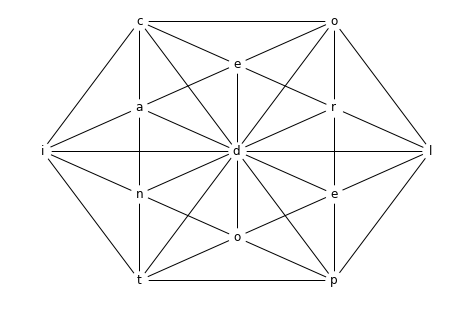

In [11]:
from collections import namedtuple
import networkx as nx

node = namedtuple('node', ['index', 'letter'])

def get_graph():
    G = nx.Graph()
    pos = [
        (1, 6), (3, 6),
        (2, 5),
        (1, 4), (3, 4),
        (0, 3), (2, 3), (4, 3),
        (1, 2), (3, 2),
        (2, 1),        
        (1, 0), (3, 0),
    ]
    nodes = [node(index=i, letter=l) for i, l in enumerate('coearidlneotp')]
    for n, p in zip(nodes, pos):
        G.add_node(n, letter=n.letter, pos=p)
    def get_edges(n0, ns):
        return [(n0, n1) for n1 in ns]
    edges = []
    for n0, ns in [
        (0, (1, 2, 3, 5, 6)),
        (1, (0, 2, 4, 6, 7)),
        (2, (0, 1, 3, 4, 6)),
        (3, (0, 2, 5, 6, 8)),
        (4, (1, 2, 6, 7, 9)),
        (5, (0, 3, 6, 8, 11)),
        (6, (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12)),
        (7, (1, 4, 6, 9, 12)),
        (8, (3, 5, 6, 10, 11)),
        (9, (4, 6, 7, 10, 12)),
        (10, (6, 8, 9, 11, 12)),
        (11, (5, 6, 8, 10, 12)),
        (12, (6, 7, 9, 10, 11))
    ]:
        edges.extend(get_edges(n0, ns))
    for (n0, n1) in edges:
        G.add_edge(nodes[n0], nodes[n1])
    return G

G = get_graph()
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos=pos, node_color='w',)
nx.draw_networkx_labels(G, pos, labels={g: g.letter for g in G})

## The Search

The idea is to search depth first but abandon the search tree if it is clear that no words are possible down that path.

In [14]:
def search_dfs(G, node, is_word, max_len=6, prefix=None):
    """Search the graph `G` starting at `node` for any words that pass `is_word`"""
    prefix = (prefix or '') + node.letter
    # print('prefix: {}'.format(prefix))
    candidates = []
    for n in G[node]:
        candidate = prefix + n.letter
        if len(candidate) == max_len:
            if is_word(candidate):
                candidates.append(candidate)
        else:
            candidates.extend(search_bfs(G, n, is_word, max_len=max_len, prefix=prefix))
    return candidates


def find_words(G, is_word, max_len=6):
    word_list = []
    for node in G:
        print(node.letter)
        w = search_dfs(G, node, is_word=is_word, max_len=max_len)
        print(w)
        word_list.extend(w)
    print('Word list:')
    print(sorted(set(word_list)))
    print('Words found:', len(set(word_list)))

find_words(G, is_word=check_word, max_len=6)

c
['cocain', 'corded', 'cordia', 'corded', 'cordon', 'canada', 'candor', 'candid', 'candle', 'canton', 'cicero', 'cicada', 'cinder', 'cinder']
o
['ordain']
e
['eroded', 'eroded', 'ederle', 'ederle']
a
['acorea', 'acedia', 'acacia', 'acadia', 'acidic', 'acinic', 'adorer', 'adored', 'adorer', 'adored', 'adonic', 'andean', 'anodic', 'antido', 'antido']
r
['rococo', 'record', 'recode', 'recode', 'recede', 'recede', 'recant', 'reader', 'reader', 'reread', 'reread']
i
['indian']
d
['decode', 'decode', 'decade', 'decade', 'decant', 'decide', 'decide', 'danaea', 'danaid', 'dander', 'dandle', 'dander', 'danton']
l
['lepton']
n
['naiant', 'nicaea', 'niacin', 'notice']
e
['eroded', 'eroded', 'ederle', 'ederle', 'elodea', 'eonian']
o
[]
t
['ticino', 'tinder', 'tinder', 'titian']
p
['pedant', 'people', 'peptic', 'ponder', 'ponder']
Word list:
['acacia', 'acadia', 'acedia', 'acidic', 'acinic', 'acorea', 'adonic', 'adored', 'adorer', 'andean', 'anodic', 'antido', 'canada', 'candid', 'candle', 'candor